In [2]:
import mne
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib qt5

In [8]:
raw = mne.io.read_raw_fif('data/110/stimulated_ieeg.fif')

Opening raw data file data/110/stimulated_ieeg.fif...
Isotrak not found
    Range : 0 ... 42983 =      0.000 ...   171.932 secs
Ready.


In [9]:
x = pd.DataFrame(raw.get_data().transpose(), columns=raw.info['ch_names'])

In [10]:
x.columns

Index(['LHip1 - LHip2', 'LHip3 - LHip4', 'RHip1 - RHip2', 'RHip3 - RHip4'], dtype='object')

In [12]:
chan = 'LHip1 - LHip2'

In [13]:
fig, ax1 = plt.subplots()
moving_avg = x[chan].rolling(25, center=True).mean() 
ax1.plot(moving_avg, color='orange')
ax1.plot(x[chan])
ax2 = ax1.twinx()
ax2.plot(moving_avg.diff().rolling(10, center=True).mean(), color='green')

In [7]:
# max_voltage = x[chan].abs().max()
# x['is_artifact'] = (x[chan].rolling(250, center=False).mean() < -0.00010) | (np.abs(x[chan]) == max_voltage)

Algo

In [8]:
x = pd.DataFrame(raw.get_data().transpose(), columns=raw.info['ch_names'])
moving_avg = x[chan].rolling(25, center=True).mean() 

max_voltage = x[chan].abs().max()
x['is_artifact'] = (np.abs(x[chan]) == max_voltage)

change_points = x[x['is_artifact'].diff() == True]['is_artifact']
print(len(change_points))

shock_cntr = 0
shock_onsets = []
shock_durations = []
for i in range(1, len(change_points)):
    if change_points[change_points.index[i]] == False:
        onset = change_points.index[i - 1]
        offset = change_points.index[i]
        duration = offset - onset
        if duration > raw.info['sfreq']:
            shock_cntr += 1
            shock_onsets.append(onset)
            print(f'onset = {onset}')
            print(f'offset = {change_points.index[i]}')
            dy = moving_avg.diff().rolling(10, center=True).mean()[offset + 5:]
            zeros = dy[np.sign(dy).diff() == +2.0]
            found_aftershock = False
            t = zeros.index[0]
            if t < offset + raw.info['sfreq'] * 3:
                print(f'found for {shock_cntr} with extra time {t - offset}')
                shock_durations.append(t - onset)
                found_aftershock = True
            if not found_aftershock:
                shock_durations.append(duration)

print(shock_cntr, len(shock_onsets), len(shock_durations))

16
onset = 13752
offset = 14160
found for 1 with extra time 92
onset = 15000
offset = 15408
found for 2 with extra time 62
onset = 16056
offset = 16464
found for 3 with extra time 42
onset = 17136
offset = 17544
found for 4 with extra time 64
onset = 28344
offset = 28752
found for 5 with extra time 60
onset = 29424
offset = 29832
found for 6 with extra time 47
onset = 30432
offset = 30840
found for 7 with extra time 80
onset = 31488
offset = 31896
found for 8 with extra time 73
8 8 8


In [9]:
x['is_artifact'] = False
for i in range(len(shock_durations)):
    x.loc[shock_onsets[i]:shock_onsets[i] + shock_durations[i], 'is_artifact'] = True

In [10]:
# a_vals = []
# for t in range(W + 1, len(d) - (W + 1)):
#     a_vals.append(is_artifact(t))

# a_vals_w_idx = np.array([range(W + 1, len(d) - (W + 1)), a_vals]).transpose()
# temp = pd.DataFrame(a_vals_w_idx, columns=['t', 'a'])
# temp['t'] = temp['t'].astype('int')
# temp = temp.set_index('t')
# x['d'] = d
# x = x.join(temp)
# x

# last_time = None
# x['is_artifact'] = False
# for artifact_time in x[x['a'] > 10].index:
#     if last_time is not None and artifact_time - last_time < 2 * raw.info['sfreq']:
#         x.loc[last_time:artifact_time + 1, 'is_artifact'] = True
#     last_time = artifact_time
# x

In [11]:
# ica = mne.preprocessing.ICA(n_components=4, max_iter='auto', random_state=97)
# ica.fit(raw)
# ica.plot_sources(raw)

Scatter

In [12]:
plt.scatter(x.index, x[chan], color=np.where(x['is_artifact'], 'red', 'blue'))

Using matplotlib as 2D backend.


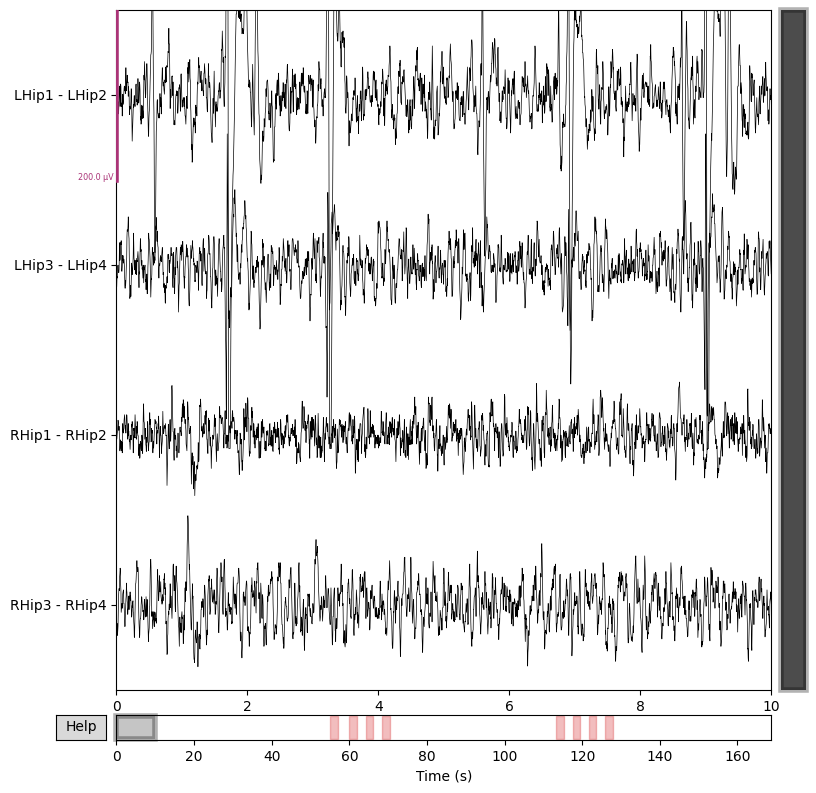

In [13]:
onsets = np.array(shock_onsets) / float(raw.info['sfreq'])
durations = np.array(shock_durations) / float(raw.info['sfreq'])
ann = mne.Annotations(onsets, durations, ['BAD_' for s in shock_durations])
raw.set_annotations(ann)
raw.plot()

In [14]:
plt.plot(x)

In [15]:
raw.info['sfreq']*46, raw.info['sfreq']*50

(11500.0, 12500.0)

Channels marked as bad: none
